In [1]:
import warnings
notebook_warnings = []
def warning_collector(message, category, filename, lineno, file=None, line=None):
    notebook_warnings.append(f"{category.__name__}: {message} (File {filename}, line {lineno})")
warnings.showwarning = warning_collector


In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2021 - 2022 United Kingdom Research and Innovation
#  Copyright 2021 - 2022 The University of Manchester
#  Copyright 2021 - 2022 Technical University of Denmark 
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Jakob S. Jørgensen (DTU)
#                   Edoardo Pasca (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)
#                   Gemma Fardell (UKRI-STFC)
#                   Hannah Robarts (UKRI-STFC)

# Key points demonstrated in this notebook:



- ### Use CIL data readers to read in data 

- ### Use CIL Processors to manipulate, reduce and preprocess projection data

- ### Use CIL Plugins for `ASTRA` or `TIGRE` toolbox for forward and back-projection

- ### Use FBP for filtered back-projection reconstruction

- ### Use CIL display tools `show2D` and `islicer` to visualise data and reconstructions

- ### Use iterative algorithms such as `SIRT` as alternative if bad data

- ### Modify image geometry to reduce reconstruction volume to save memory and time

# Data-set used in this notebook:

  ### If you are running the notebook locally, install the data (`usb.zip`) from: https://zenodo.org/record/4822516#.YvJW5vfTXu0

First import all modules we will need:

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt

from cil.io import ZEISSDataReader, TIFFWriter
from cil.processors import TransmissionAbsorptionConverter, CentreOfRotationCorrector, Slicer
from cil.framework import AcquisitionData
from cil.plugins.astra import FBP
from cil.utilities.display import show2D, show1D, show_geometry
from cil.utilities.jupyter import islicer, link_islicer

Load the 3D cone-beam projection data of the USB:

In [4]:
# Please set the filename yourself, if you are running the notebook locally:
filename = "/mnt/share/materials/SIRF/Fully3D/CIL/Usb/gruppe 4_2014-03-20_1404_12/tomo-A/gruppe 4_tomo-A.txrm"

data = ZEISSDataReader(file_name=filename).read()

The data is loaded in as a CIL `AcquisitionData` object:

In [5]:
type(data)

cil.framework.acquisition_data.AcquisitionData

We can call `print` for the data to get some basic information:

In [6]:
print(data)

Number of dimensions: 3
Shape: (801, 1024, 1024)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



Note how labels refer to the different dimensions. We infer that this data set contains 801 projections each size 1024x1024 pixels.

In addition to the data itself, `AcquisitionData` contains geometric metadata in an `AcquisitionGeometry` object in the `geometry` field, which can be printed for more detailed information:

In [7]:
print(data.geometry)

3D Cone-beam tomography
System configuration:
	Source position: [  0.        , -95.04837036,   0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.        , 55.08220291,  0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1024 1024]
	Pixel size: [0.06585435 0.06585435]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 801
	Angles 0-9 in radians: [-3.1415493, -3.1337836, -3.125914 , -3.1180005, -3.1102147, -3.1023476,
 -3.0945017, -3.0866468, -3.0787883, -3.0709336]
	Angles 791-800 in radians: [3.070867 , 3.0787256, 3.086563 , 3.0945282, 3.1023111, 3.110163 ,
 3.1180265, 3.1258702, 3.1337245, 3.1416595]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


CIL can illustrate the scan setup visually from the AcquisitionData geometry:

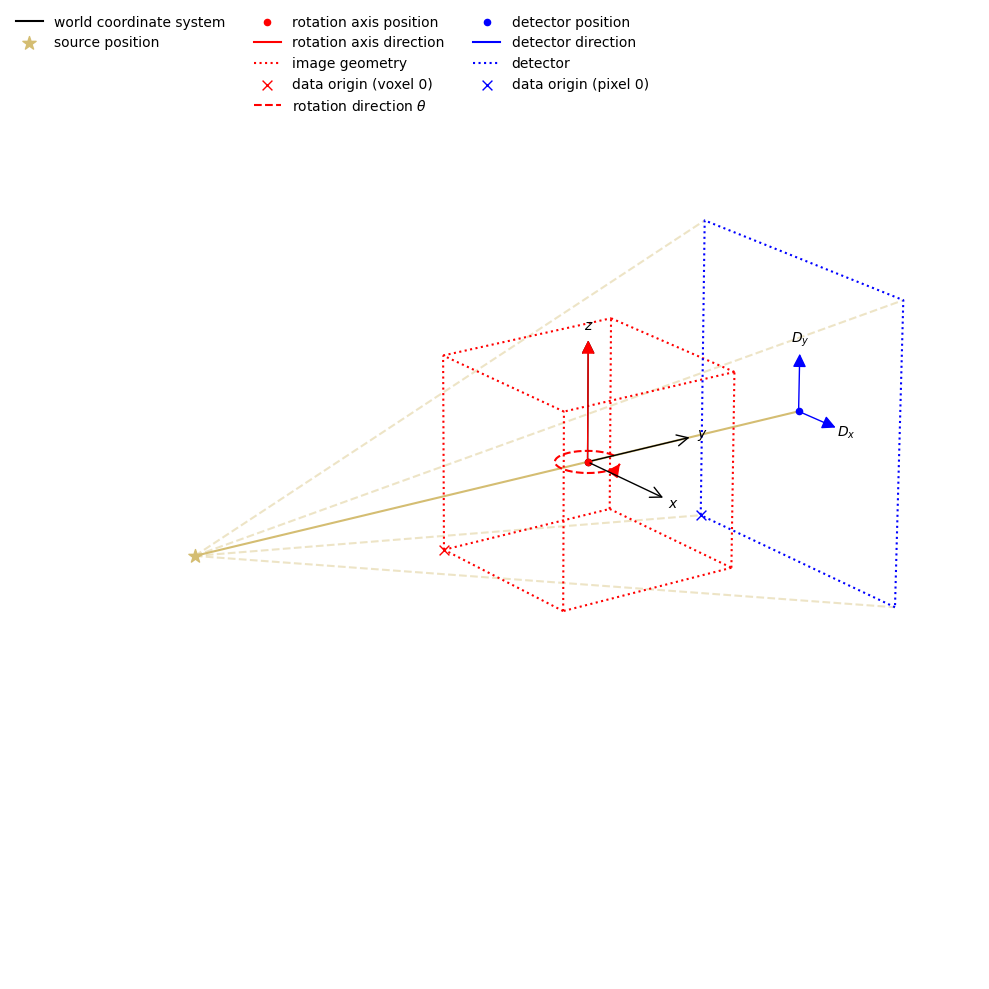

In [8]:
show_geometry(data.geometry)

We can use the dimension labels to extract and display 2D slices of data, such as a single projection:

In [9]:
show2D(data, slice_list=('angle',220))

From the background value of 1.0 we infer that the data is transmission data (it is known to be already centered and flat field corrected) so we just need to convert to absorption/apply the negative logarithm, which can be done using a CIL processor, which will handle small/large outliers:

In [10]:
data = TransmissionAbsorptionConverter()(data)

We again take a look at a slice of the data, now a vertical one to see the central slice sinogram after negative logarithm:

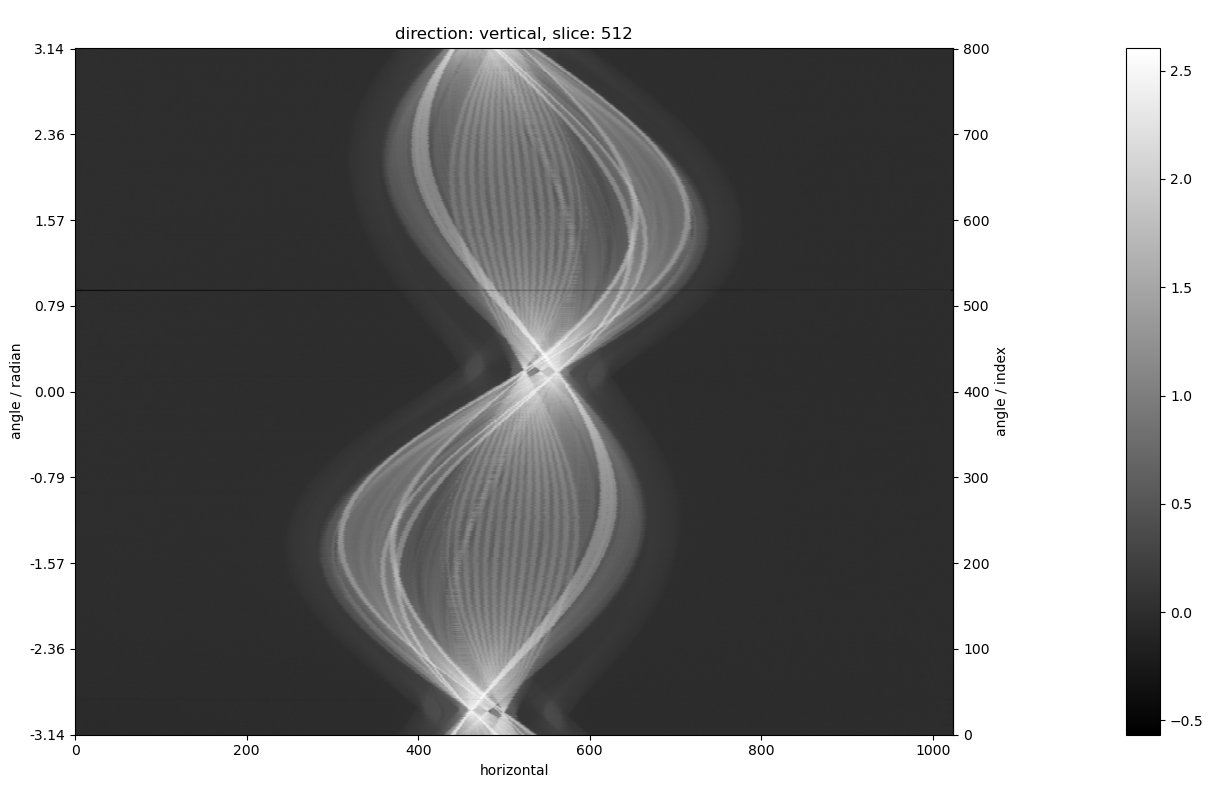

In [11]:
show2D(data, slice_list=('vertical',512))

## Crop data by 200 pixels on both sides to save memory and computation time

New geometry:  3D Cone-beam tomography
System configuration:
	Source position: [  0.        , -95.04837036,   0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.        , 55.08220291,  0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [ 624 1024]
	Pixel size: [0.06585435 0.06585435]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 801
	Angles 0-9 in radians: [-3.1415493, -3.1337836, -3.125914 , -3.1180005, -3.1102147, -3.1023476,
 -3.0945017, -3.0866468, -3.0787883, -3.0709336]
	Angles 791-800 in radians: [3.070867 , 3.0787256, 3.086563 , 3.0945282, 3.1023111, 3.110163 ,
 3.1180265, 3.1258702, 3.1337245, 3.1416595]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (801, 1024, 624)


New geometry shape:  (801, 1024, 624)


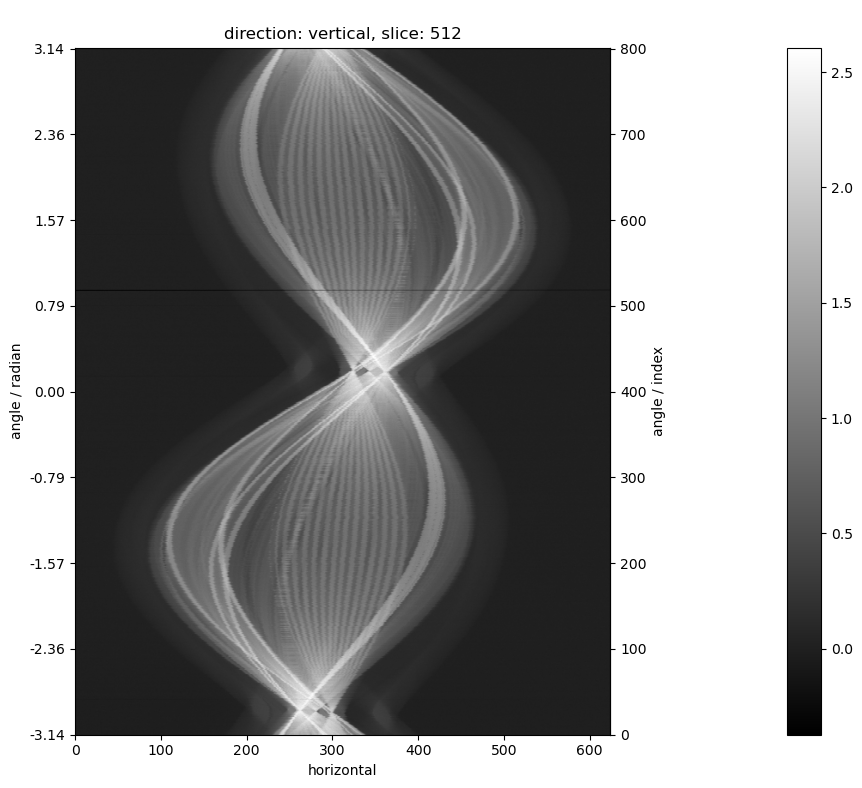

In [12]:
data = Slicer(roi={'horizontal':(200,-200)})(data)
show2D(data, slice_list=('vertical',512))

CIL supports different back-ends for which data order conventions may differ. Here we use the FBP algorithm from the ASTRA Toolbox, which requires us to permute the data array into the right order:

In [13]:
data.dimension_labels

(<AcquisitionDimension.ANGLE: 'angle'>,
 <AcquisitionDimension.VERTICAL: 'vertical'>,
 <AcquisitionDimension.HORIZONTAL: 'horizontal'>)

In [14]:
data.reorder(order='astra')
data.dimension_labels

(<AcquisitionDimension.VERTICAL: 'vertical'>,
 <AcquisitionDimension.ANGLE: 'angle'>,
 <AcquisitionDimension.HORIZONTAL: 'horizontal'>)

The data is now ready for reconstruction. To set up the FBP algorithm we must specify the size/geometry of the reconstruction volume. Here we use the default one:

In [15]:
ig = data.geometry.get_ImageGeometry()

We can then create the FBP algorithm (really FDK since 3D cone-beam) from ASTRA running on the GPU and reconstruct the data:

In [16]:
fbp =  FBP(ig, data.geometry)
recon = fbp(data)

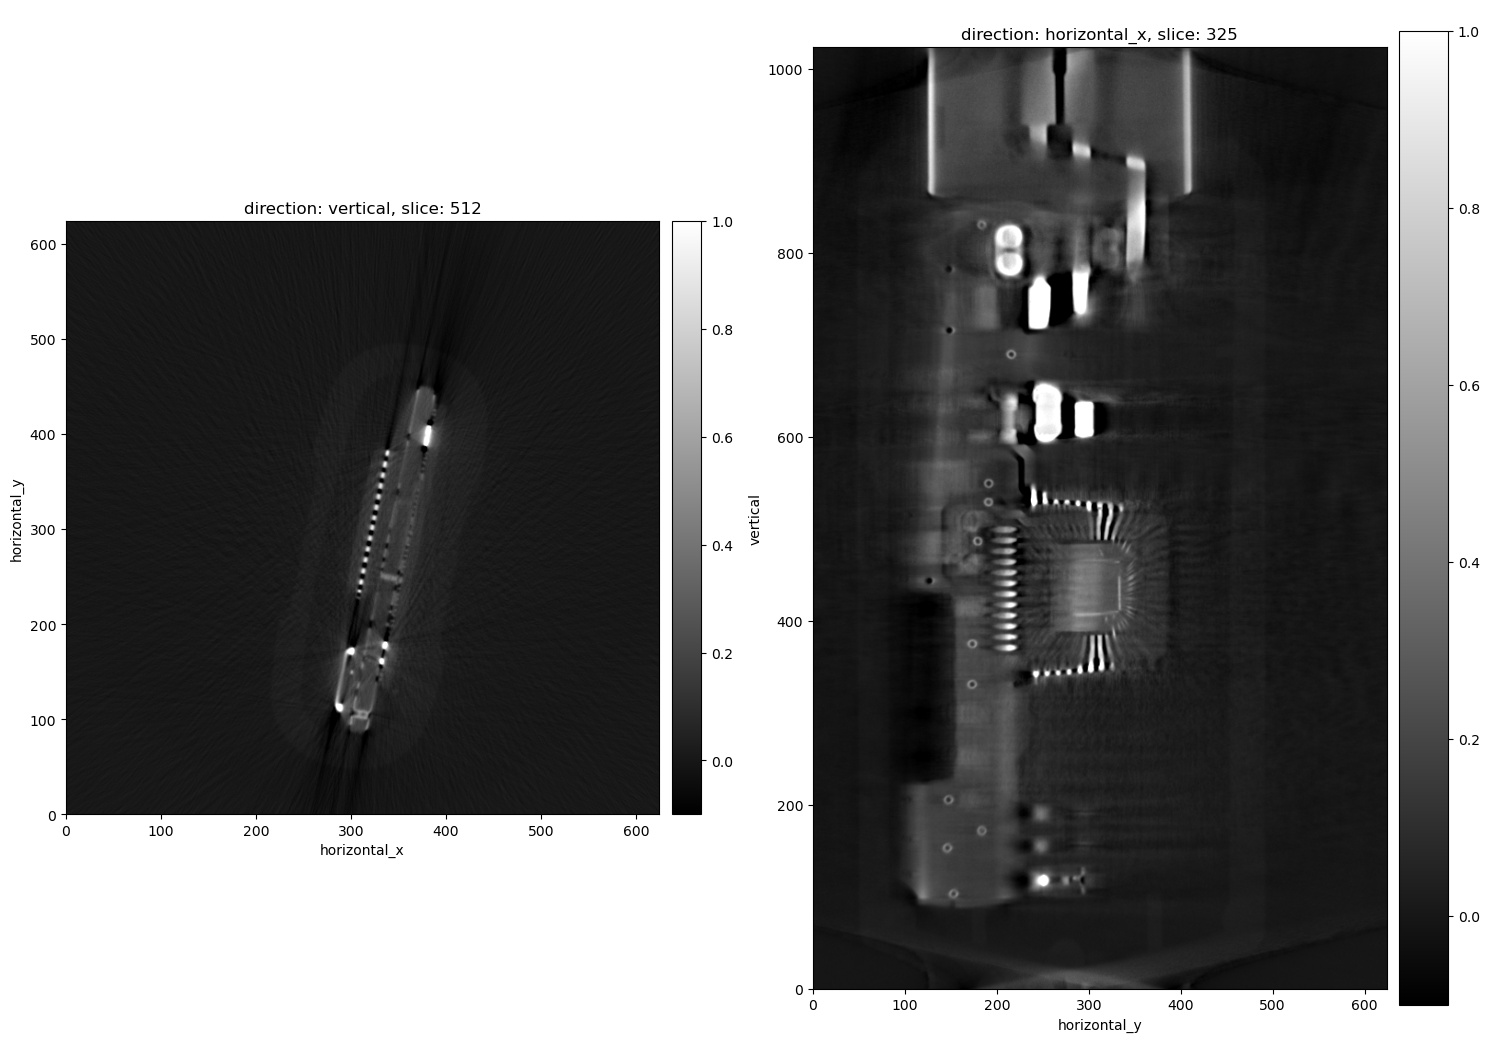

In [17]:
show2D(recon, slice_list=[('vertical',512), ('horizontal_x', 325)], fix_range=(-0.1,1))

## Offset initial angle to align reconstruction

In [18]:
# Note: The ZEISSDataReader reads the angles as radians, so we need to set the angle unit here:
data.geometry.set_angles(data.geometry.angles, initial_angle=-11.5*np.pi/180, angle_unit='radian')


In [19]:
fbp =  FBP(ig, data.geometry)
recon = fbp(data)

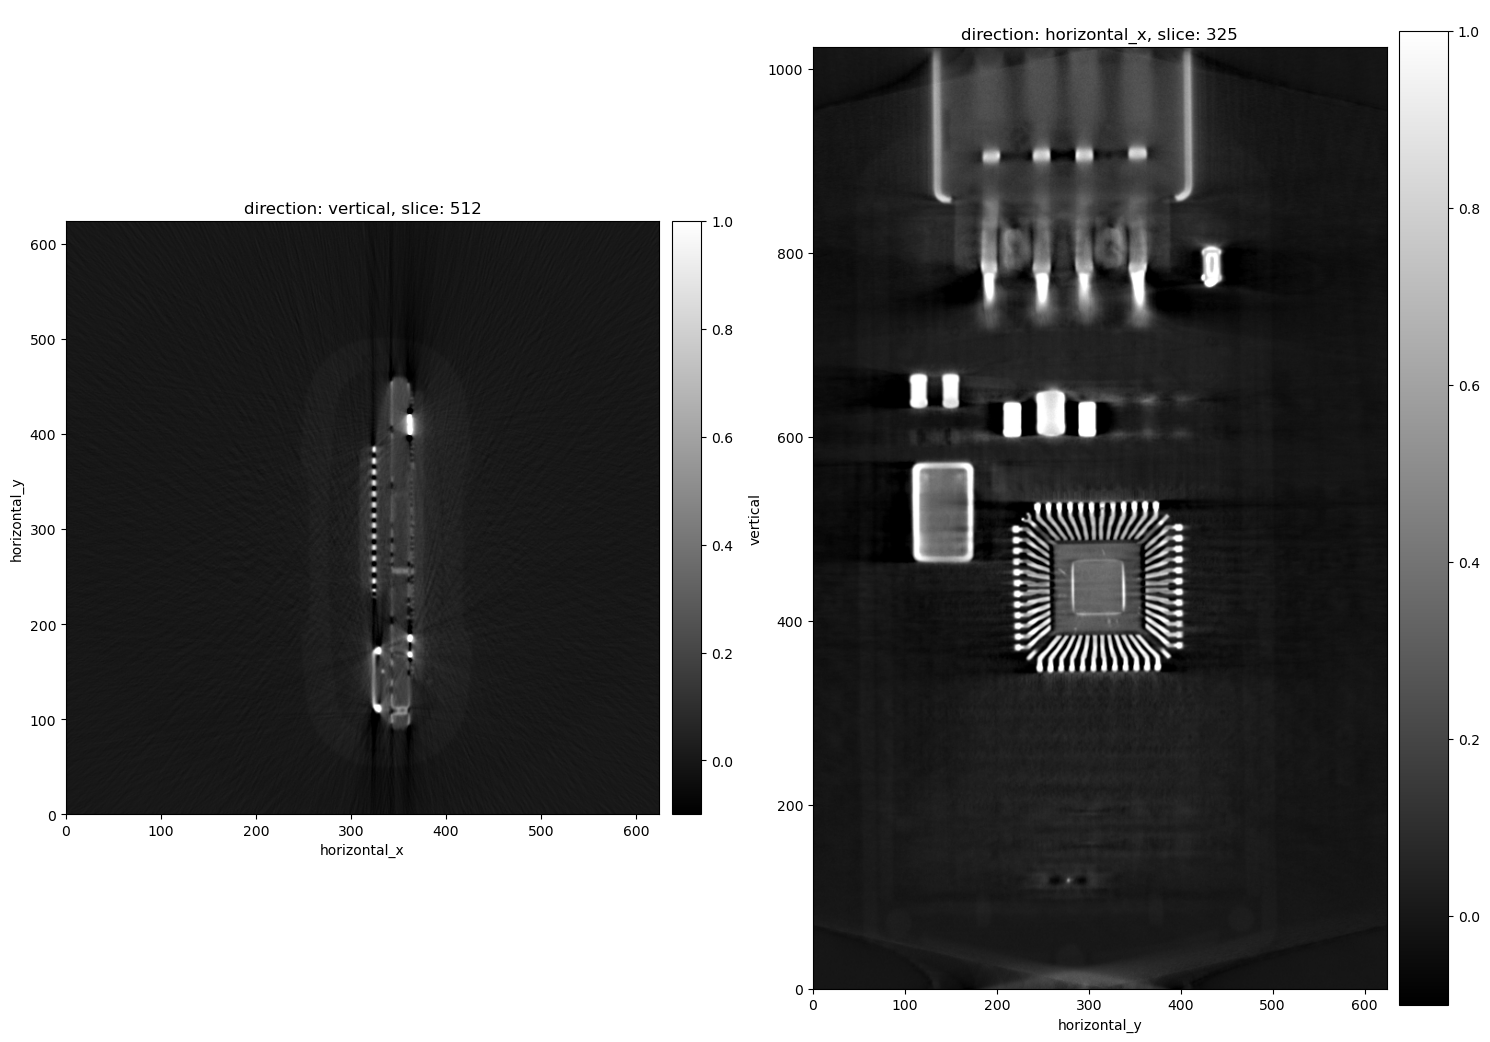

In [20]:
show2D(recon, slice_list=[('vertical',512), ('horizontal_x', 325)], fix_range=(-0.1,1))

## Use interactive islicer to flick through slices

In [21]:
islicer(recon,direction='vertical',size=10, minmax=(0.1,1))

In [22]:
islicer(recon,direction='horizontal_x',size=10, minmax=(0.1,1))

## Extract and reconstruct only central 2D slice

In [23]:
data2d = data.get_slice(vertical='centre')

In [24]:
data2d.dimension_labels

(<AcquisitionDimension.ANGLE: 'angle'>,
 <AcquisitionDimension.HORIZONTAL: 'horizontal'>)

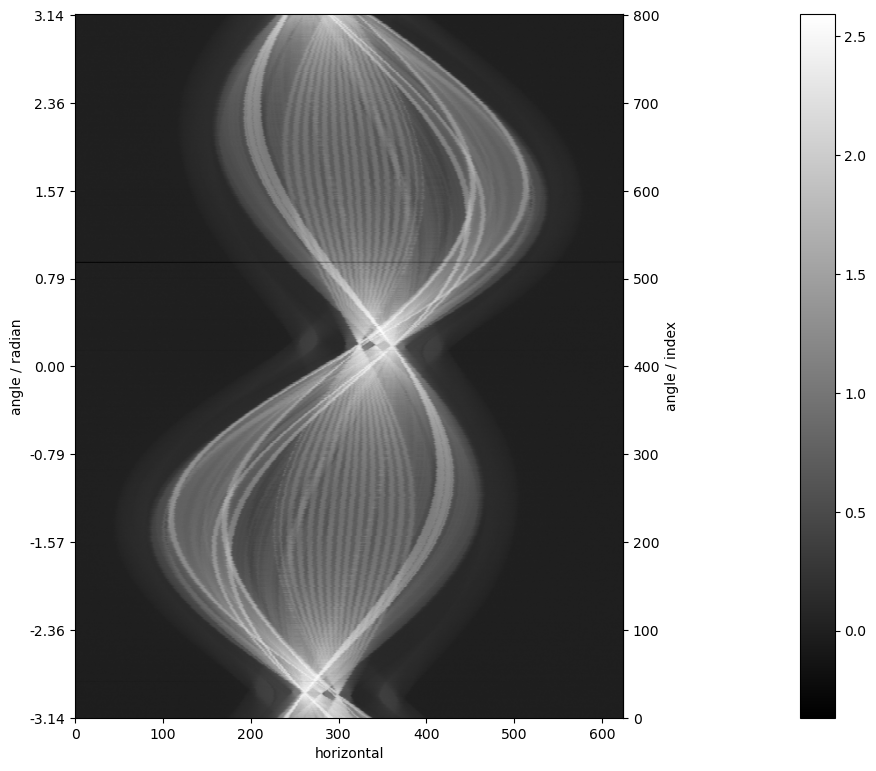

In [25]:
show2D(data2d)

In [26]:
ig2d = data2d.geometry.get_ImageGeometry()

In [27]:
recon2d = FBP(ig2d,data2d.geometry)(data2d)

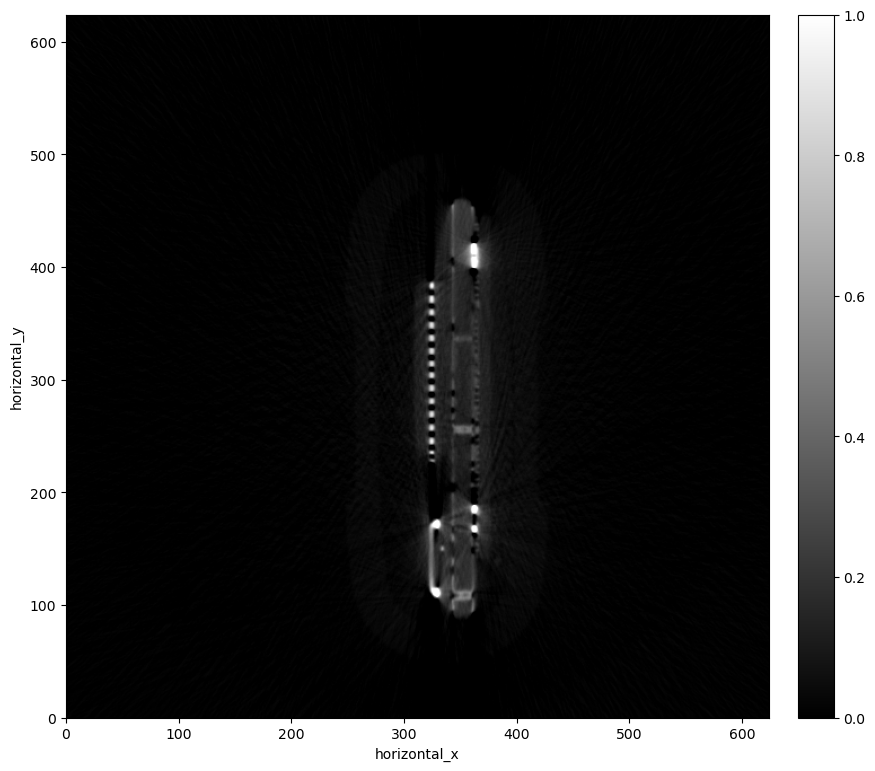

In [28]:
show2D(recon2d,fix_range=(0,1))

## Simulate limited angle scenario with few projections

In [29]:
idx = [*range(50,400,10)] +  [*range(450,800,10)] 

# A number of other projection index ranges tried
# idx = [*range(50,350,10)] + [*range(450,750,10)] #+ [*range(400,500)] + [*range(600,700)]
# idx = [*range(50,150,10)] +  [*range(200,350,10)] + [*range(450,550,10)] + [*range(600,750,10)]
# idx = [*range(25,375,10)] +  [*range(425,775,10)]
# idx = [*range(0,125,10)] +  [*range(275,525,10)] + [*range(675,800,10)]
# idx = [*range(50,200,5)] + [*range(300,450,10)] + [*range(550,800,20)]
# idx = [*range(100,350,10)] +  [*range(500,750,10)]
# idx = [*range(0,100,20)] + [*range(350,500,20)] +  [*range(750,800,20)]

Text(0.5, 1.0, 'Limited and few angles')

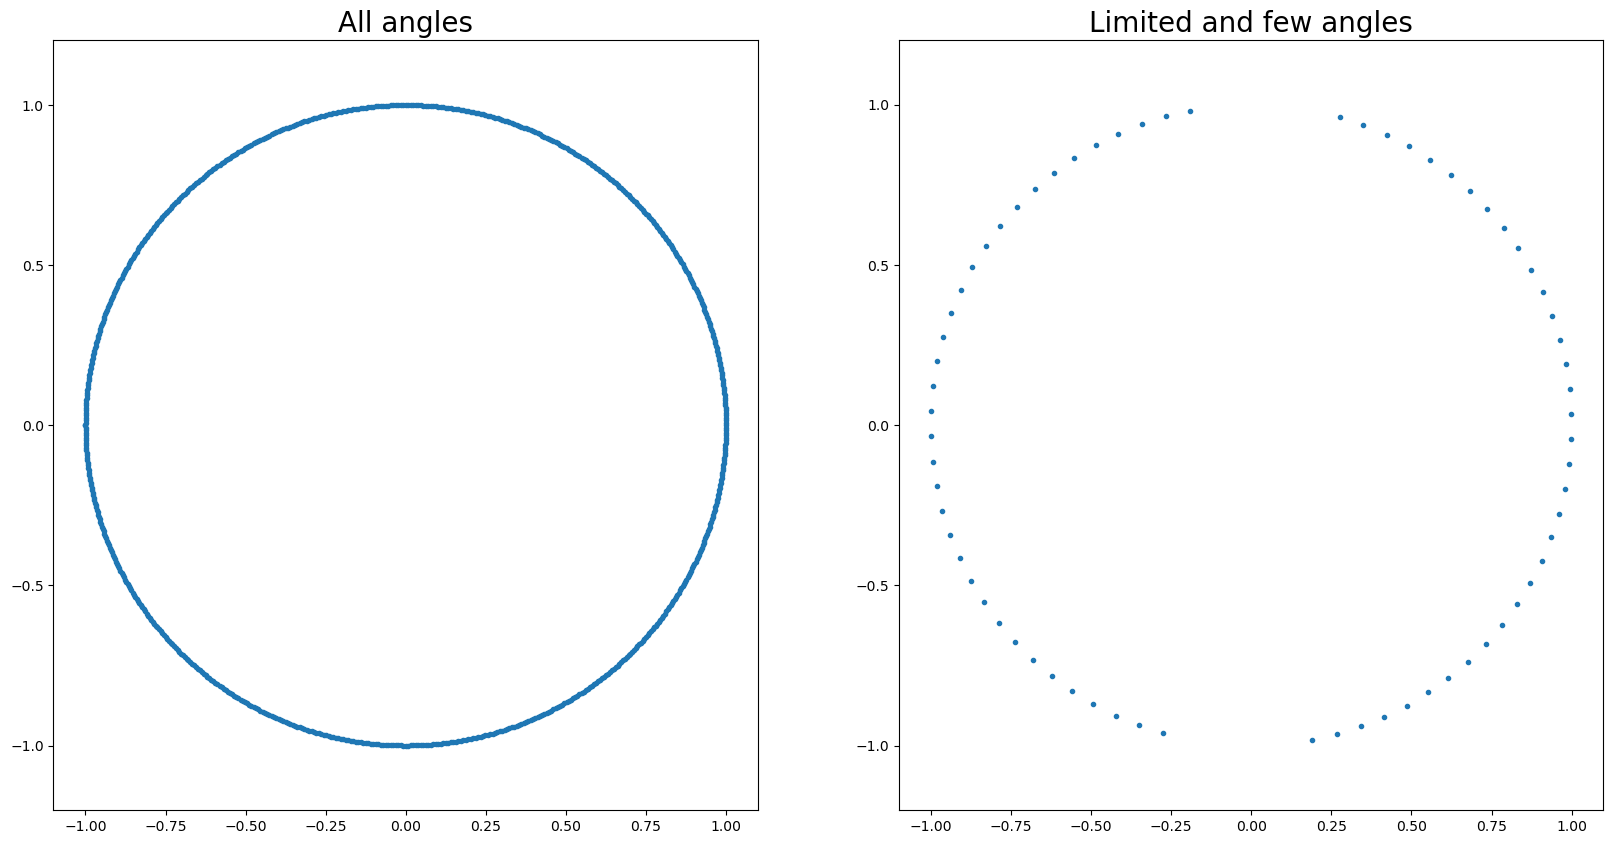

In [30]:
plt.figure(figsize=(20,10)).set_facecolor('xkcd:white')

plt.subplot(1,2,1)
plt.plot(np.cos(data2d.geometry.angles), np.sin(data2d.geometry.angles),'.')
plt.axis('equal')
plt.title('All angles',fontsize=20)

plt.subplot(1,2,2)
plt.plot(np.cos(data2d.geometry.angles[idx]+(90-11.5)*np.pi/180), np.sin(data2d.geometry.angles[idx]+(90-11.5)*np.pi/180),'.')
plt.axis('equal')
plt.title('Limited and few angles',fontsize=20)

## Manually extract numpy array with selected projections only

In [31]:
data_array = data2d.as_array()[idx,:]

In [32]:
data_array.shape

(70, 624)

In [33]:
data2d.as_array().shape

(801, 624)

## Create updated geometry with selected angles only

In [34]:
ag_reduced = data2d.geometry.copy()

In [35]:
ag_reduced.set_angles(ag_reduced.angles[idx], initial_angle=-11.5*np.pi/180, angle_unit='radian')

## Combine to new `AcquisitionData` with selected data only

In [36]:
data2d_reduced = AcquisitionData(data_array, geometry=ag_reduced)

## Reconstruct by FBP

In [37]:
recon2d_reduced = FBP(ig2d,ag_reduced)(data2d_reduced)

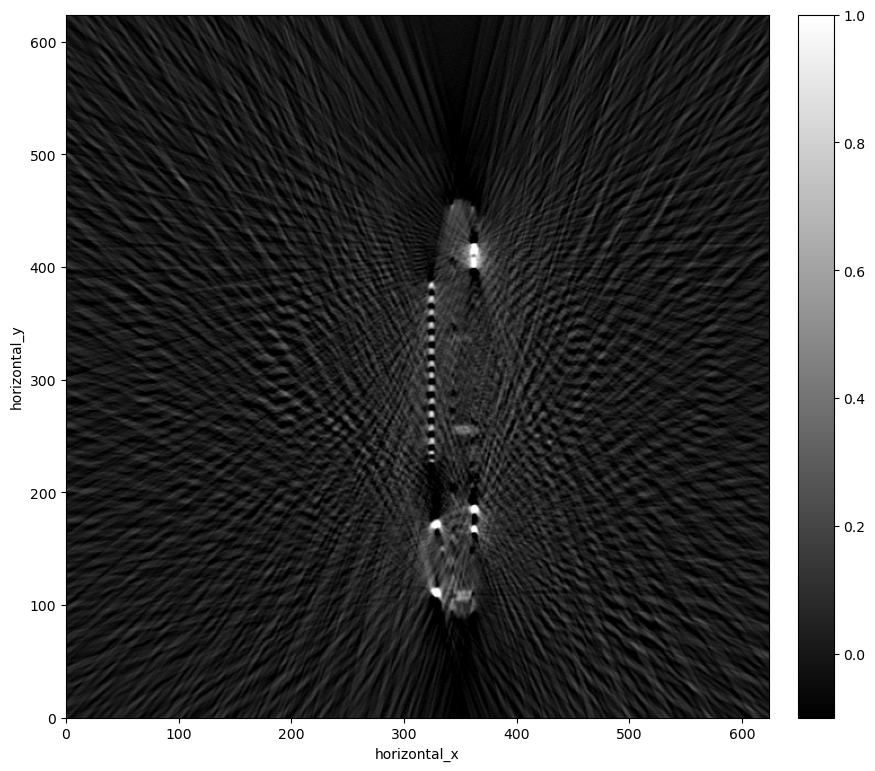

In [38]:
show2D(recon2d_reduced, fix_range=(-0.1,1))

## Try iterative SIRT reconstruction

Now set up the discrete linear inverse problem `Ax = b` and solve weighted least-squares problem using the SIRT algorithm:

In [39]:
from cil.plugins.astra.operators import ProjectionOperator
from cil.optimisation.algorithms import SIRT

In [40]:
A = ProjectionOperator(ig2d, ag_reduced, device="gpu")

## Specify initial guess and initialise algorithm

In [41]:
x0 = ig2d.allocate(0.0)

In [42]:
mysirt = SIRT(initial=x0, operator=A, data=data2d_reduced)

## Run a low number of iterations and inspect intermediate result

In [43]:
mysirt.run(10, verbose=1)

  0%|          | 0/10 [00:00<?, ?it/s]

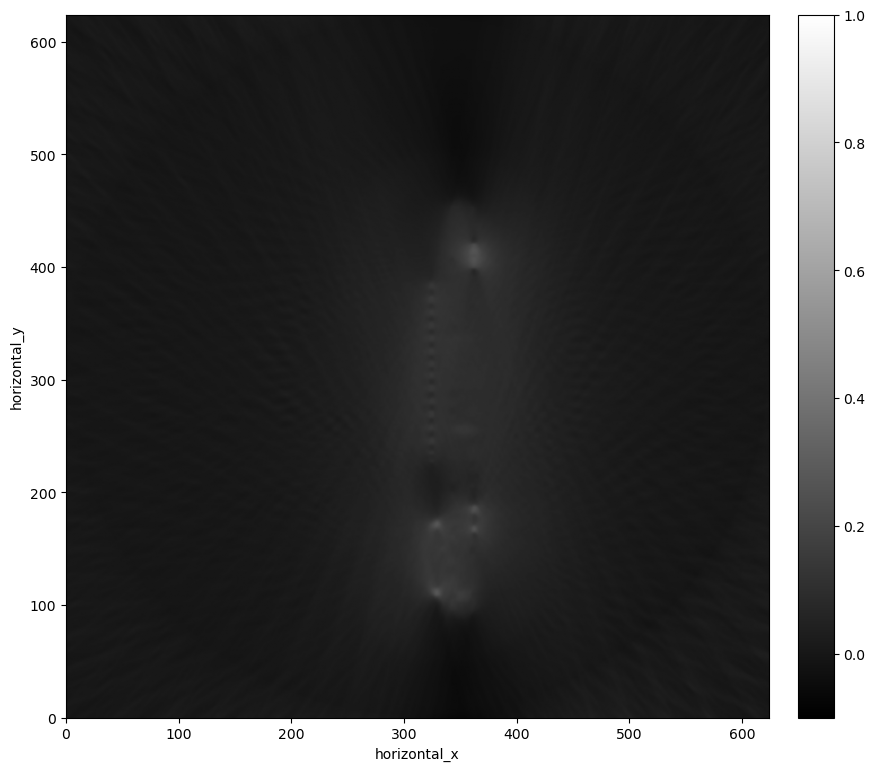

In [44]:
show2D(mysirt.solution, fix_range=(-0.1, 1))

## Run more iterations and inspect

In [45]:
mysirt.run(90, verbose=1)

 11%|#1        | 11/100 [00:00<?, ?it/s]

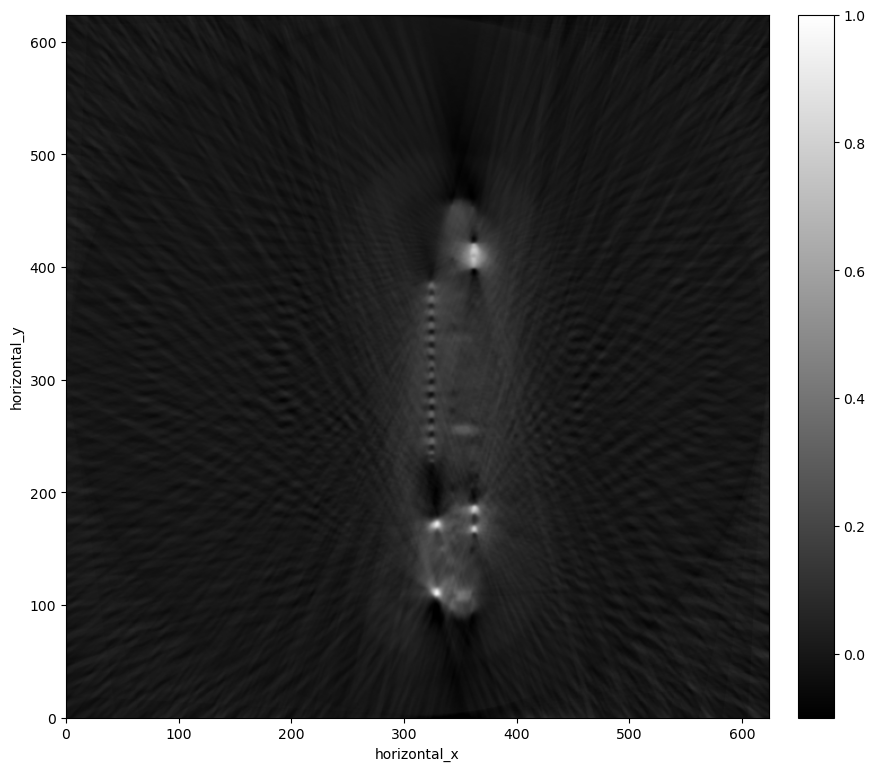

In [46]:
show2D(mysirt.solution, fix_range=(-0.1, 1))

## Run even more iterations for final SIRT reconstruction

In [47]:
mysirt.run(900, verbose=1)

 10%|#         | 101/1000 [00:00<?, ?it/s]

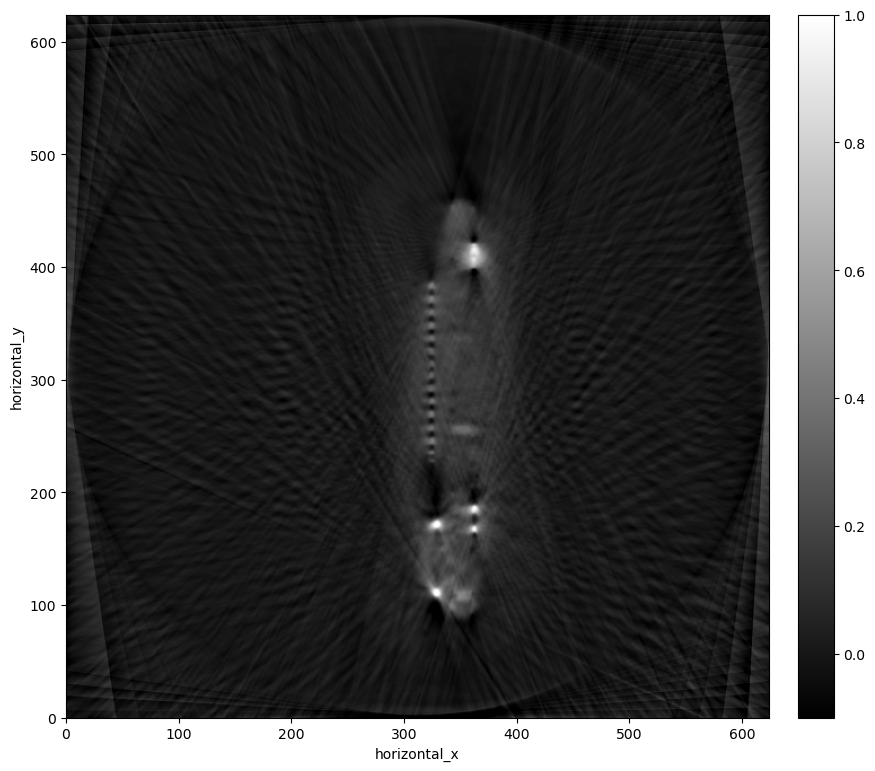

In [48]:
show2D(mysirt.solution, fix_range=(-0.1, 1))

## Add non-negativity constraint using input `lower=0.0`

In [49]:
mysirt_lower0 = SIRT(initial=x0, operator=A, data=data2d_reduced, lower=0.0, update_objective_interval=50)

In [50]:
mysirt_lower0.run(1000, verbose=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/_monitor.py", line 84, in run
    instance.refresh(nolock=True)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/notebook.py", line 157, in display
    pbar.value = self.n
    ^^^^^^^^^^
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/bgb37

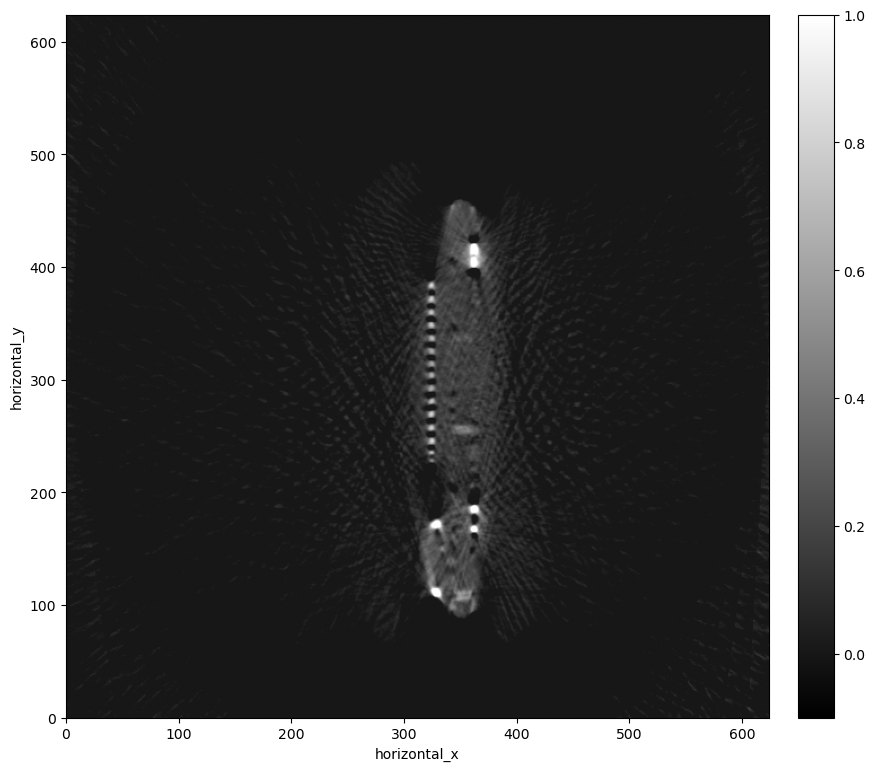

In [51]:
show2D(mysirt_lower0.solution, fix_range=(-0.1, 1))

## Compare all reduced data reconstructions in tighter colour range

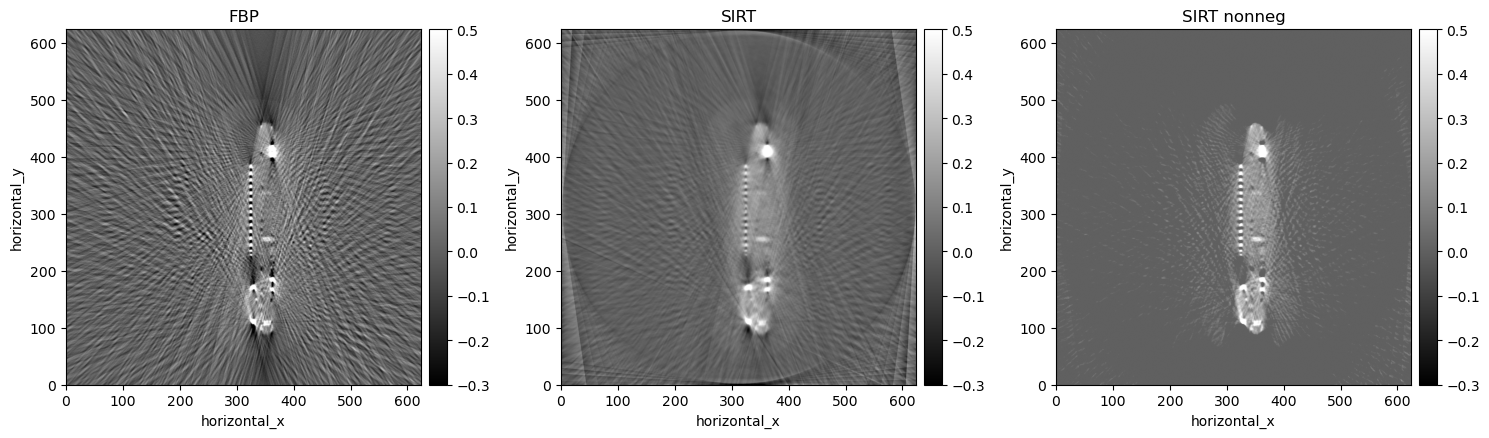

In [52]:
show2D([recon2d_reduced, mysirt.solution, mysirt_lower0.solution], title=["FBP","SIRT","SIRT nonneg"], num_cols=3, fix_range=(-0.3,0.5))

## Compare horizontal line profiles 

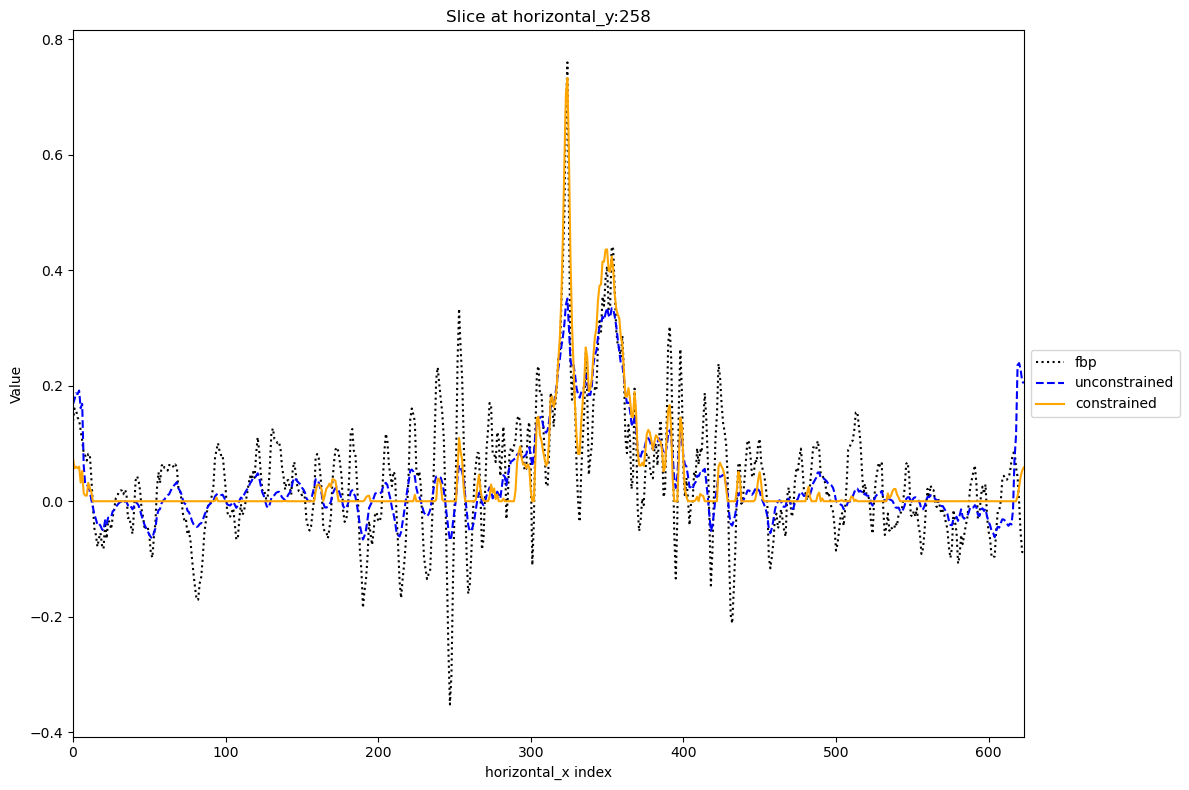

In [53]:
linenumy = 258

show1D([recon2d_reduced,mysirt.solution,mysirt_lower0.solution],
       slice_list=[('horizontal_y',linenumy)],
       dataset_labels=['fbp','unconstrained','constrained'],
      line_colours=['black','blue','orange'],
      line_styles=['dotted','dashed','solid'],
      size=(12,8))

## Go back to full data FBP reconstruction, adjust reconstruction geometry to save time and memory

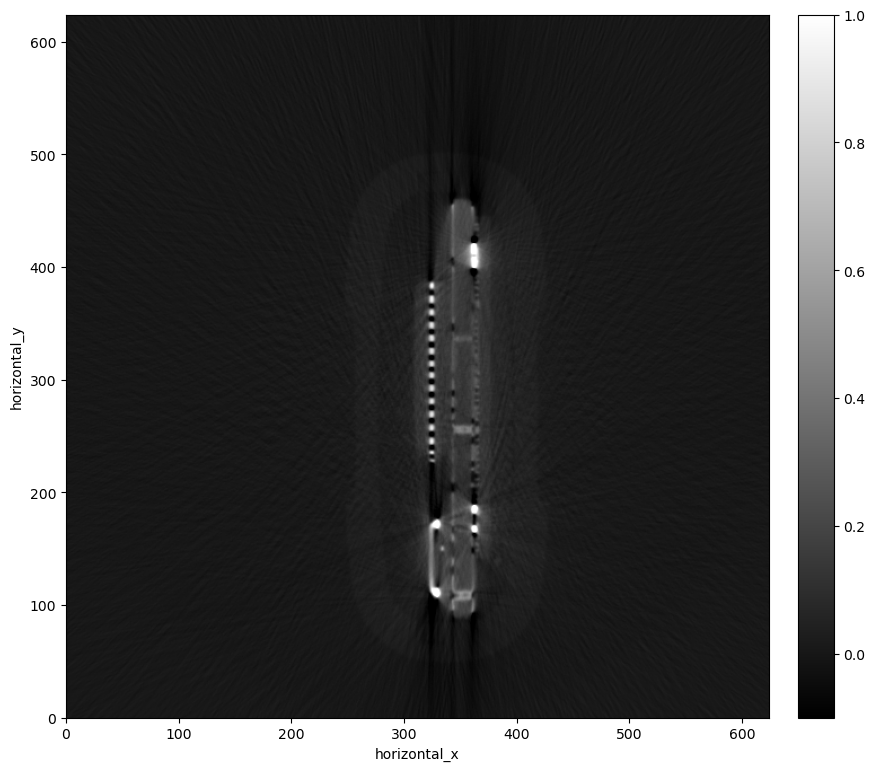

In [54]:
show2D(recon2d,fix_range=(-0.1,1))

In [55]:
print(ig2d)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x624,y624
voxel_size : x0.041692699432373054,y0.041692699432373054
center : x0,y0



## Reduce the number of voxels

In [56]:
ig2d.voxel_num_x = 200
ig2d.voxel_num_y = 500

In [57]:
print(ig2d)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x200,y500
voxel_size : x0.041692699432373054,y0.041692699432373054
center : x0,y0



In [58]:
recon2d = FBP(ig2d, data2d.geometry)(data2d)
show2D(recon2d,fix_range=(0,1))

## Centre the reconstruction volume around the sample:

In [59]:
ig2d.center_x = 30*ig2d.voxel_size_x
ig2d.center_y = -40*ig2d.voxel_size_y

In [60]:
print(ig2d)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x200,y500
voxel_size : x0.041692699432373054,y0.041692699432373054
center : x1.2507809829711916,y-1.6677079772949222



In [61]:
recon2d = FBP(ig2d,data2d.geometry)(data2d)
show2D(recon2d,fix_range=(0,1))

## Further reduce the reconstruction volume

In [62]:
ig2d.voxel_num_x = 100
ig2d.voxel_num_y = 400

In [63]:
print(ig2d)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x100,y400
voxel_size : x0.041692699432373054,y0.041692699432373054
center : x1.2507809829711916,y-1.6677079772949222



In [64]:
recon2d = FBP(ig2d,data2d.geometry)(data2d)
show2D(recon2d,fix_range=(0,1))

In [65]:
print(ig2d)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x100,y400
voxel_size : x0.041692699432373054,y0.041692699432373054
center : x1.2507809829711916,y-1.6677079772949222



## Increase voxel size by a factor

In [66]:
ig2d.voxel_size_x = 4*ig2d.voxel_size_x
ig2d.voxel_size_y = 4*ig2d.voxel_size_y
print(ig2d)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x100,y400
voxel_size : x0.16677079772949222,y0.16677079772949222
center : x1.2507809829711916,y-1.6677079772949222



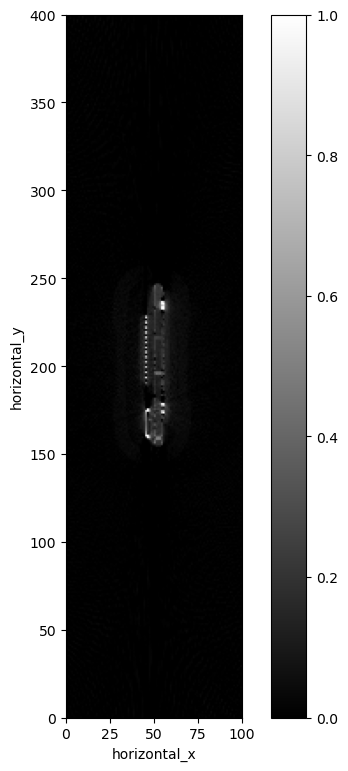

In [67]:
recon2d = FBP(ig2d,data2d.geometry)(data2d)
show2D(recon2d,fix_range=(0,1))

## Reduce number of voxels by same factor

In [68]:
ig2d.voxel_num_x = 25
ig2d.voxel_num_y = 100

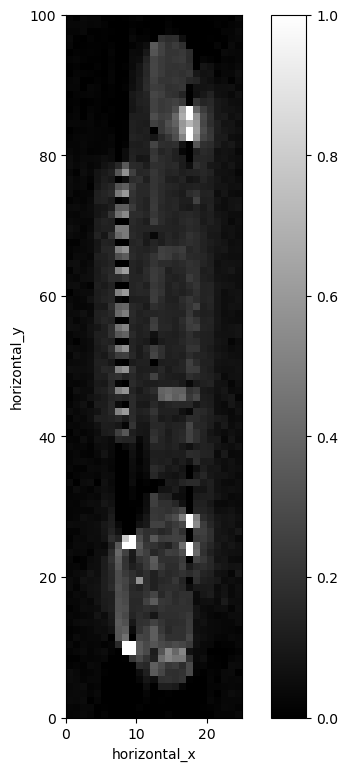

In [69]:
recon2d = FBP(ig2d,data2d.geometry)(data2d)
show2D(recon2d,fix_range=(0,1))